In [1]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
from sklearn  import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
sns.set_theme()

/Users/nas/Documents/MRP/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Hyper parameters
########
num_of_feature = 8 # number of input features for LSTM and GRU network
past_observation = 6 # Number of past hours data used as input to the LSTM and GRU network
##########

######## Model Parameters # 
hidden_layers_unit = [128, 64,32,16]
return_sequence = [True, True, True,False]
batch_size = 64
num_of_epoch = 100



# Read dataset

In [3]:
# Import Dataset

traffic_data = pd.read_csv("/Users/nas/Documents/MRP/dataset/Metro_Interstate_Traffic_Volume.csv")
traffic_data = traffic_data.set_index(pd.DatetimeIndex(traffic_data['date_time'])).rename(columns={"date_time": "ds"})
traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)

/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/1340887147.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)


In [4]:
traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159


In [5]:
traffic_data = traffic_data.drop_duplicates()

In [6]:
# Checking for any missing or empty value
traffic_data.isna().sum()

holiday                48126
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
ds                         0
traffic_volume             0
dtype: int64

# convert categorical to nominal data

In [7]:
# Convert categorical value to numerical values. For holiday attribute, value will be within by 0 and 1. If it is holiday then 1 otherwise 0
label_encoder = preprocessing.LabelEncoder()
traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
traffic_data['weather_description'] = label_encoder.fit_transform(traffic_data['weather_description'])

/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/1522180088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/1522180088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/1522180088.py:5: Set

In [8]:
traffic_data.describe()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
count,48187.0,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187,48187.000000
mean,1.0,281.204995,0.334382,0.000222,49.365451,2.578642,16.540021,2016-01-05 06:49:48.133729024,3259.618134
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000
25%,1.0,272.160000,0.000000,0.000000,1.000000,0.000000,10.000000,2014-02-06 07:30:00,1192.500000
50%,1.0,282.450000,0.000000,0.000000,64.000000,1.000000,17.000000,2016-06-10 21:00:00,3379.000000
75%,1.0,291.806000,0.000000,0.000000,90.000000,5.000000,27.000000,2017-08-11 05:30:00,4933.000000
max,1.0,310.070000,9831.300000,0.510000,100.000000,10.000000,37.000000,2018-09-30 23:00:00,7280.000000
std,0.0,13.338738,44.797033,0.008169,39.015213,2.784148,8.969561,NaN,1986.954465


<Axes: xlabel='date_time'>

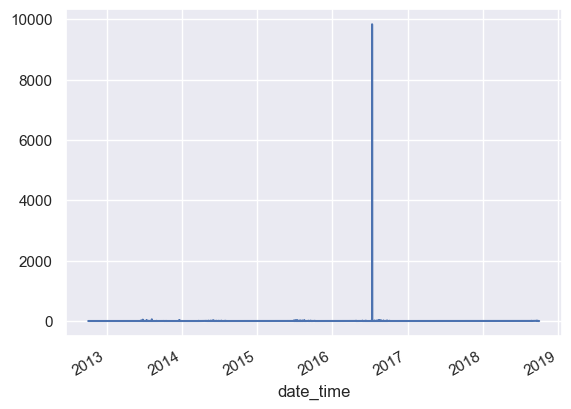

In [9]:
#traffic_data['temp'].plot()
traffic_data['rain_1h'].plot()


<Axes: xlabel='date_time'>

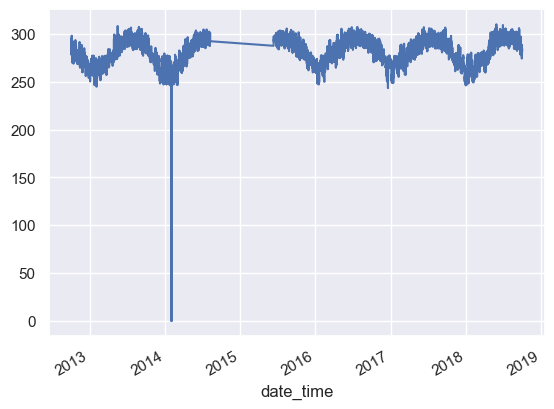

In [10]:
traffic_data['temp'].plot()

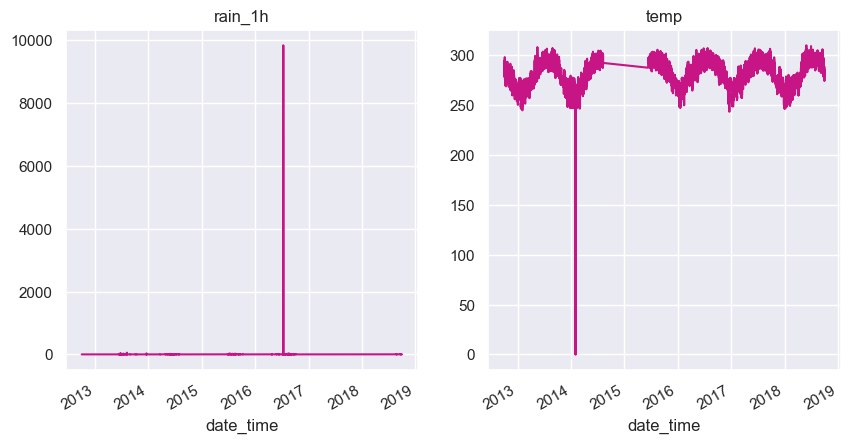

In [11]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("/Users/nas/Documents/MRP/dataset/images/with_outlier.png", dpi=1200)

In [12]:
Q1 = traffic_data.quantile(0.25)
Q3 = traffic_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

holiday                               0.0
temp                               19.646
rain_1h                               0.0
snow_1h                               0.0
clouds_all                           89.0
weather_main                          5.0
weather_description                  17.0
ds                     1281 days 22:00:00
traffic_volume                     3740.5
dtype: object


In [13]:
traffic_data=traffic_data[~((traffic_data['temp'] <(Q1['temp']-1.5*IQR['temp'])) | (traffic_data['temp'] >(Q1['temp']+1.5*IQR['temp'])))]
traffic_data=traffic_data[~((traffic_data['traffic_volume'] <(Q1['traffic_volume']-1.5*IQR['traffic_volume'])) | (traffic_data['traffic_volume'] >(Q1['traffic_volume']+1.5*IQR['traffic_volume'])))]

# Prepare training and testing data

<Axes: xlabel='date_time'>

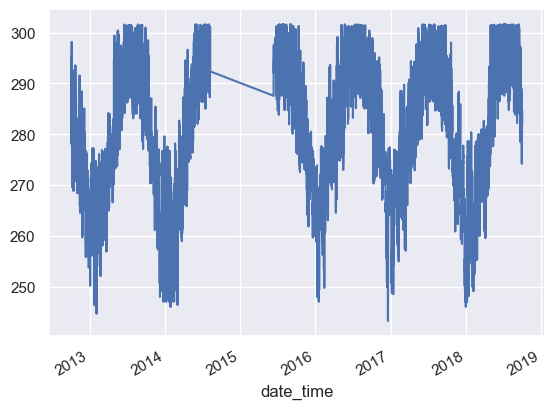

In [14]:
# ploting traffic data to see to see any data imbalance
traffic_data['temp'].plot()

<Axes: xlabel='date_time'>

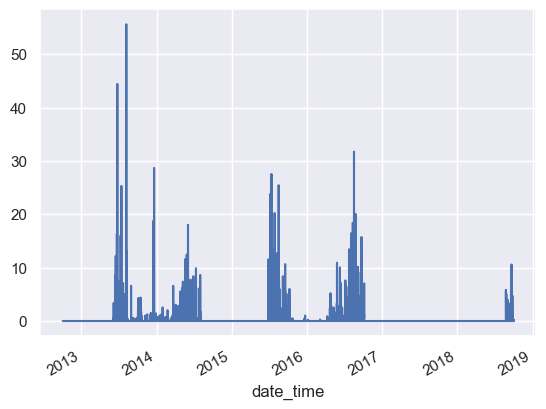

In [15]:
traffic_data['rain_1h'].plot()

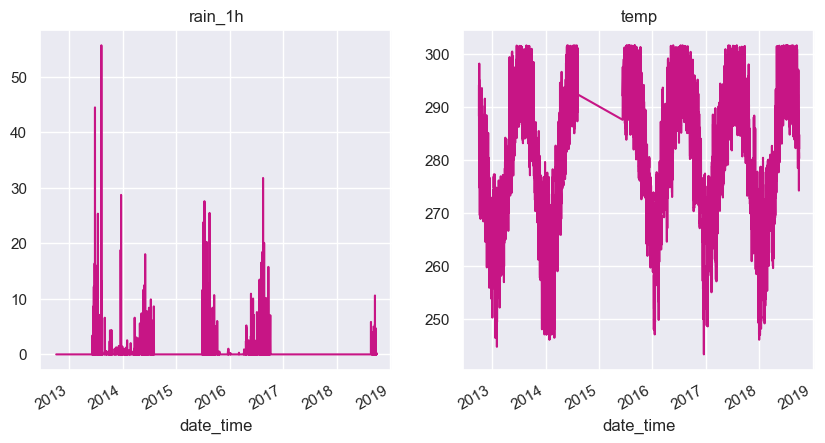

In [16]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("/Users/nas/Documents/MRP/dataset/images/without_outlier.png", dpi=1200)

In [17]:

traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,1,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,1,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,1,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,1,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,1,283.45,0.0,0.0,75,1,2,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,1,282.76,0.0,0.0,90,1,19,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,1,282.73,0.0,0.0,90,10,21,2018-09-30 21:00:00,2159


In [18]:
split_date = '2018-01-01'
train_data = traffic_data.loc[traffic_data.index <= split_date].copy()
test_data = traffic_data.loc[traffic_data.index > split_date].copy()

In [19]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)

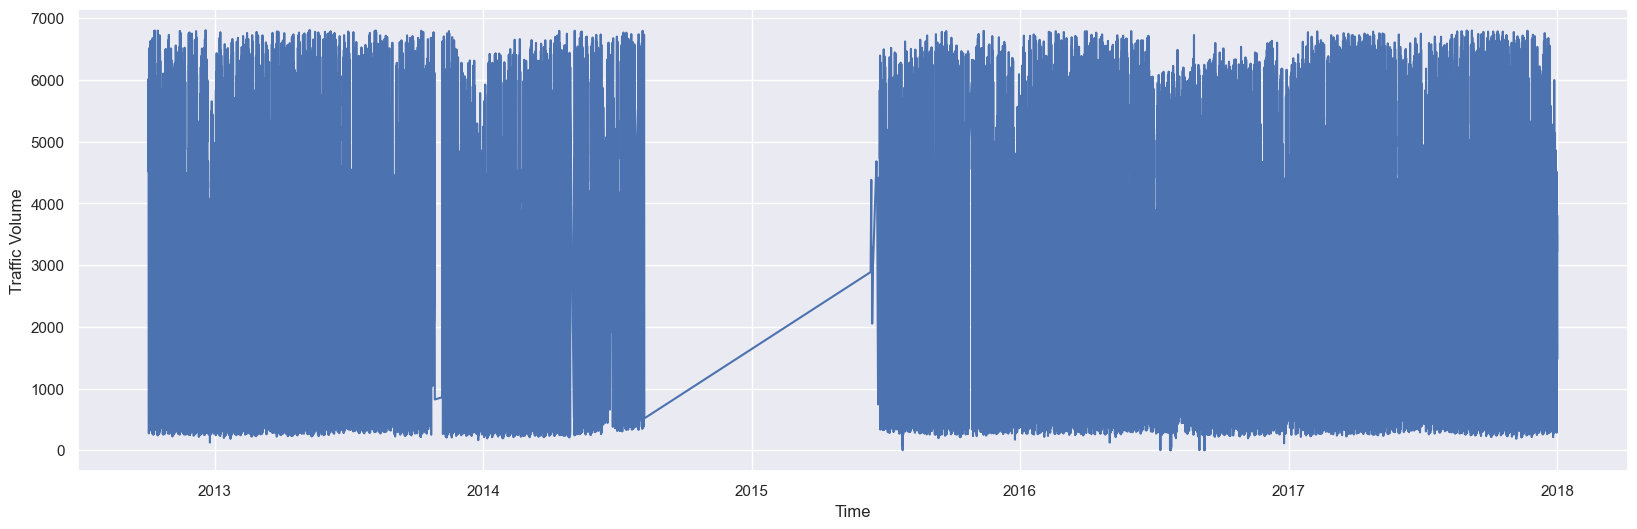

In [20]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_data['ds'])
time_valid = np.array(test_data['ds'])

plt.figure(figsize=(20,6))
plot_series(time_train, x_train)

In [21]:
train_data_without_ds = train_data.drop(columns=['ds'])
train_data_without_ds
test_data_without_ds = test_data.drop(columns=['ds'])
test_data_without_ds

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2018-01-01 01:00:00,1,249.08,0.0,0.0,1,0,27,1408
2018-01-01 02:00:00,1,248.86,0.0,0.0,1,0,27,931
2018-01-01 03:00:00,1,248.72,0.0,0.0,1,0,27,585
2018-01-01 04:00:00,1,248.43,0.0,0.0,1,0,27,381
2018-01-01 05:00:00,1,248.07,0.0,0.0,1,0,27,434
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,1,283.45,0.0,0.0,75,1,2,3543
2018-09-30 20:00:00,1,282.76,0.0,0.0,90,1,19,2781
2018-09-30 21:00:00,1,282.73,0.0,0.0,90,10,21,2159


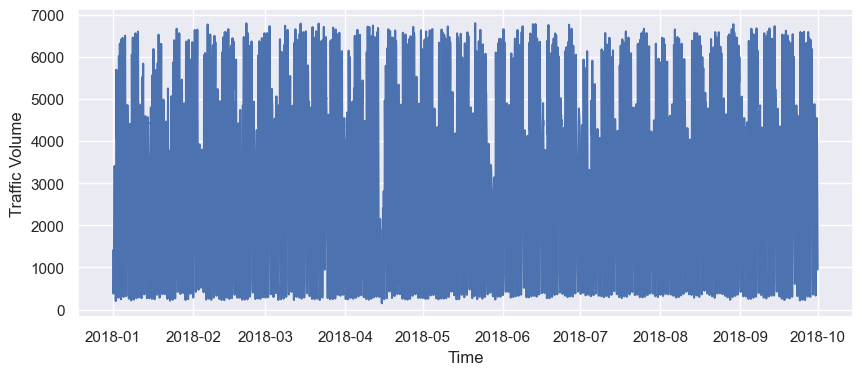

In [22]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_data['ds'])
time_valid = np.array(test_data['ds'])

plt.figure(figsize=(10,4))
plot_series(time_valid, x_valid)

In [23]:
# Values of the attribute are in different scales. For example, holiday has maximum value 1 and traffic volume let say, 2000. Since these values are totally different range, it might be hurt model learning process. To overcome this issue, we need to do data normalization or standarization.
sc = MinMaxScaler()
sc_test = MinMaxScaler()
training_data_set = sc.fit_transform(train_data_without_ds)
training_data_frame = pd.DataFrame(training_data_set)
test_data_set = sc_test.fit_transform(test_data_without_ds)
test_data_frame = pd.DataFrame(test_data_set)


In [24]:
# Make data for the LSTM model. I used past t-hours of data to predict the next 'n' hours data. Here window_size means window size data will be used for predicting next 'n' hours data

def df_to_x_y(data, window_size=5):
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [r for r in data[i:i+window_size]]
        X.append(row)
        label = data[i+window_size][num_of_feature-1]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_x_y(training_data_set,past_observation)
X.shape, y.shape

((39374, 6, 8), (39374,))

In [25]:
# X test y Test
X_test, y_test = df_to_x_y(test_data_set, past_observation)
X_test.shape, y_test.shape

((7622, 6, 8), (7622,))

In [26]:
# split data into train test and validation datase
from cgi import test


train_length = int(len(X)*0.8) # 80% trainging
validation_length = int(len(X)*.20) # 10% testing and rest for validation
print(train_length, validation_length, (train_length+validation_length))
X_train, y_train = X[:train_length],y[:train_length]
X_val, y_val = X[train_length:], y[train_length:]

31499 7874 39373


In [27]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)


(((31499, 6, 8), (31499,)), ((7875, 6, 8), (7875,)))

In [29]:
# Define LSTM_Model
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(hidden_layers_unit[0], return_sequences=return_sequence[0], input_shape=(past_observation, num_of_feature)))
for i in range(1, len(hidden_layers_unit)):
    LSTM_Model.add(LSTM(hidden_layers_unit[i], return_sequences=return_sequence[i]))
LSTM_Model.add(Dense(1))

# Compile the model
LSTM_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])


/Users/nas/Documents/MRP/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# Define GRU_Model
GRU_Model = Sequential()
GRU_Model.add(GRU(hidden_layers_unit[0], return_sequences=return_sequence[0], input_shape=(past_observation, num_of_feature)))
for i in range(1, len(hidden_layers_unit)):
    GRU_Model.add(GRU(hidden_layers_unit[i], return_sequences=return_sequence[i]))
GRU_Model.add(Dense(1))

# Compile the model
GRU_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])


In [32]:
LSTM_CheckPoint = ModelCheckpoint('model/model_lstm_'+str(past_observation)+'.keras', save_best_only=True)


In [33]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(patience=10)
LSTM_history = LSTM_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[LSTM_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

In [34]:
# Define GRU_Model and GRU_CheckPoint
GRU_Model = Sequential()
GRU_Model.add(GRU(hidden_layers_unit[0], return_sequences=return_sequence[0], input_shape=(past_observation, num_of_feature)))
for i in range(1, len(hidden_layers_unit)):
    GRU_Model.add(GRU(hidden_layers_unit[i], return_sequences=return_sequence[i]))
GRU_Model.add(Dense(1))

GRU_CheckPoint = ModelCheckpoint('model/model_gru_'+str(past_observation)+'.keras', save_best_only=True)

# Compile and fit the model
GRU_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])
GRU_history = GRU_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[GRU_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

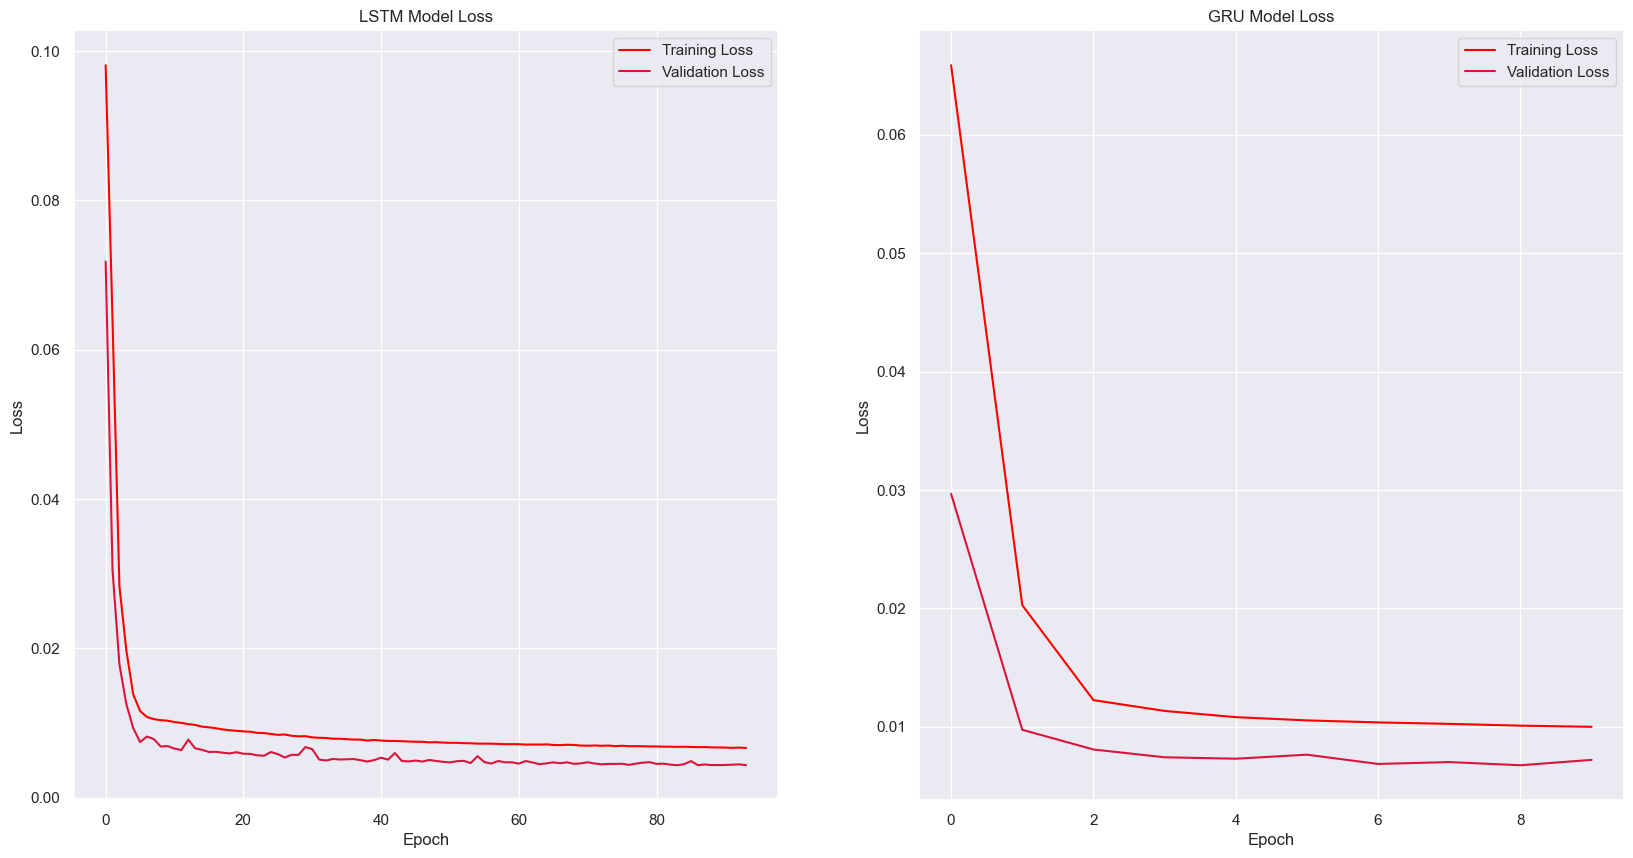

In [35]:

# summarize history for loss
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(LSTM_history.history['loss'], color='red')
ax[0].plot(LSTM_history.history['val_loss'], color='crimson')
ax[0].set_title('LSTM Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1].plot(GRU_history.history['loss'], color='red')
ax[1].plot(GRU_history.history['val_loss'], color='crimson')
ax[1].set_title('GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig("/Users/nas/Documents/MRP/dataset/images/training_loss_"+ str(past_observation)+".png", dpi=1200)
plt.show()

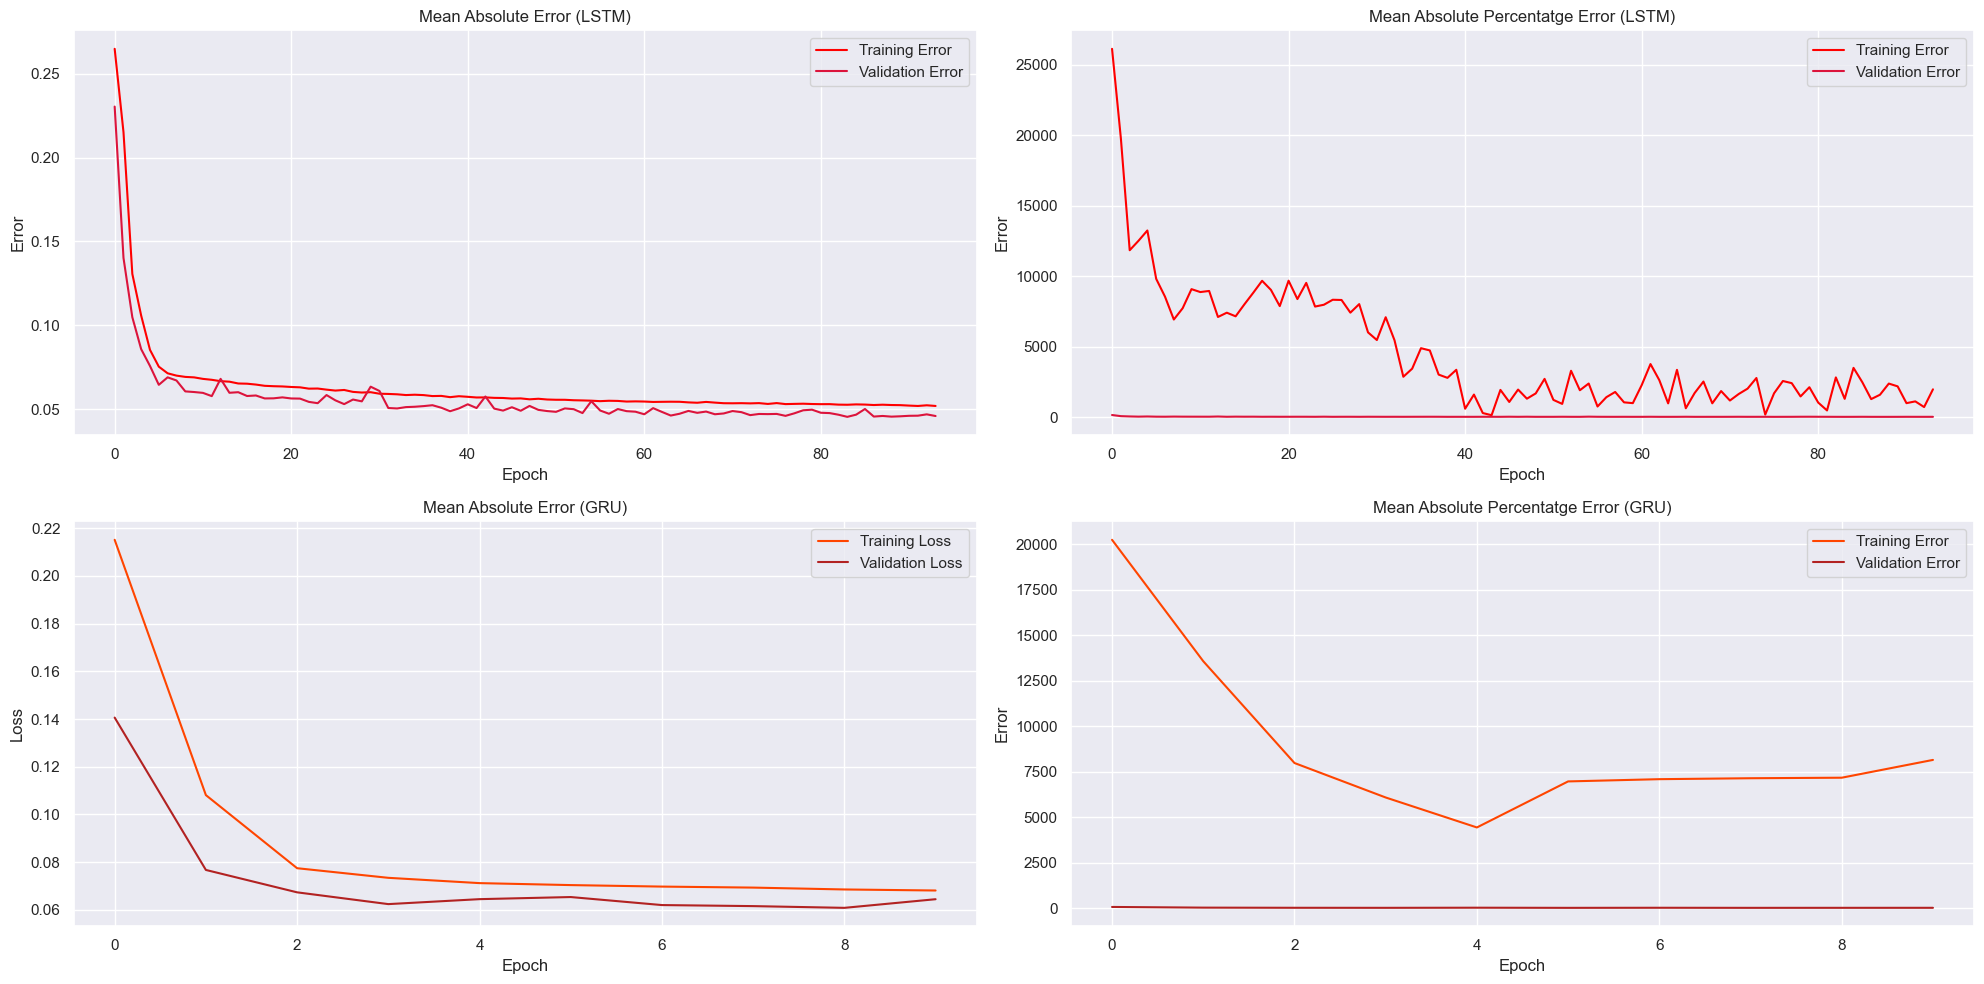

In [36]:
# summarize history for loss
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0][0].plot(LSTM_history.history['mean_absolute_error'], color='red')
ax[0][0].plot(LSTM_history.history['val_mean_absolute_error'], color='crimson')
ax[0][0].set_title('Mean Absolute Error (LSTM)')
ax[0][0].set_ylabel('Error')
ax[0][0].set_xlabel('Epoch')
ax[0][0].legend(['Training Error', 'Validation Error'], loc='upper right')

ax[0][1].plot(LSTM_history.history['mean_absolute_percentage_error'], color='red')
ax[0][1].plot(LSTM_history.history['val_mean_absolute_percentage_error'], color='crimson')
ax[0][1].set_title('Mean Absolute Percentatge Error (LSTM)')
ax[0][1].set_ylabel('Error')
ax[0][1].set_xlabel('Epoch')
ax[0][1].legend(['Training Error', 'Validation Error'], loc='upper right')


ax[1][0].plot(GRU_history.history['mean_absolute_error'], color='orangered')
ax[1][0].plot(GRU_history.history['val_mean_absolute_error'], color='firebrick')
ax[1][0].set_title('Mean Absolute Error (GRU)')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1][1].plot(GRU_history.history['mean_absolute_percentage_error'], color='orangered')
ax[1][1].plot(GRU_history.history['val_mean_absolute_percentage_error'], color='firebrick')
ax[1][1].set_title('Mean Absolute Percentatge Error (GRU)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Epoch')
ax[1][1].legend(['Training Error', 'Validation Error'], loc='upper right')
fig.tight_layout()
plt.savefig("/Users/nas/Documents/MRP/dataset/images/mean_absolute_error_loss_"+str(past_observation)+".png", dpi=1200)
plt.show()

In [37]:
from tensorflow.keras.models import load_model

# Load or define your LSTM model
lstm_model = load_model('/Users/nas/Documents/MRP/Traffic-Volume-Prediction-LSTM-GRU-main/model/model_lstm_6.keras')

# Save the LSTM model
lstm_model.save('model_lstm_' + str(past_observation) + '.h5')

# Load or define your GRU model
gru_model = load_model('/Users/nas/Documents/MRP/Traffic-Volume-Prediction-LSTM-GRU-main/model/model_gru_6.keras')

# Save the GRU model
gru_model.save('model_gru_' + str(past_observation) + '.h5')


In [38]:
lstm_model.save('model_lstm_' + str(past_observation) + '.h5')
gru_model.save('model_gru_' + str(past_observation) + '.h5')


In [39]:
lstm_model = load_model('model_lstm_' + str(past_observation) + '.h5')
gru_model = load_model('model_gru_' + str(past_observation) + '.h5')


In [40]:
from tensorflow.keras.models import load_model

# Specify the full file path to your LSTM and GRU model files
lstm_model_path = '/Users/nas/Documents/MRP/Traffic-Volume-Prediction-LSTM-GRU-main/model/model_lstm_6.keras'
gru_model_path = '/Users/nas/Documents/MRP/Traffic-Volume-Prediction-LSTM-GRU-main/model/model_gru.keras'

# Load the LSTM and GRU models
lstm_model = load_model(lstm_model_path)
gru_model = load_model(gru_model_path)


In [41]:
lstm_prediction = lstm_model.predict(X_test)
gru_prediction = gru_model.predict(X_test)

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [42]:
from tabnanny import verbose


lstm_evaluation = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_evaluation = gru_model.evaluate(X_test, y_test, verbose=0)

In [43]:
(lstm_evaluation, gru_evaluation)

([0.004643684718757868, 0.04651646316051483, 12467.3935546875],
 0.03894883394241333)

In [45]:
if isinstance(gru_evaluation, float):
    print(f'GRU: Loss: {np.round(gru_evaluation,4)}, Mean Absolute Error: N/A, MAPE: N/A')
else:
    print(f'GRU: Loss: {np.round(gru_evaluation[0],4)}, Mean Absolute Error: {np.round(gru_evaluation[1],4)}, MAPE: {np.round(gru_evaluation[2],4)}')


GRU: Loss: 0.0389, Mean Absolute Error: N/A, MAPE: N/A


In [46]:
lstm_Y = np.repeat(lstm_prediction, num_of_feature, axis=1)
lstm_y_inverse = sc_test.inverse_transform(lstm_Y)
gru_Y = np.repeat(gru_prediction, num_of_feature, axis=1)
gru_y_inverse = sc_test.inverse_transform(gru_Y)

In [47]:
Y_test = np.repeat(y_test, num_of_feature)
Y_test = Y_test.reshape(-1,num_of_feature)
Y_Test_transfer = sc_test.inverse_transform(Y_test)

In [48]:
lstm_Y_pred = lstm_y_inverse[:, 7]
gru_Y_pred = gru_y_inverse[:,7]
actual_Y_test = Y_Test_transfer[:, 7]

In [49]:
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.plot(time[start:end], series_true[start:end],format)
    plt.plot(time[start:end], series_pred[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)
    plt.show()

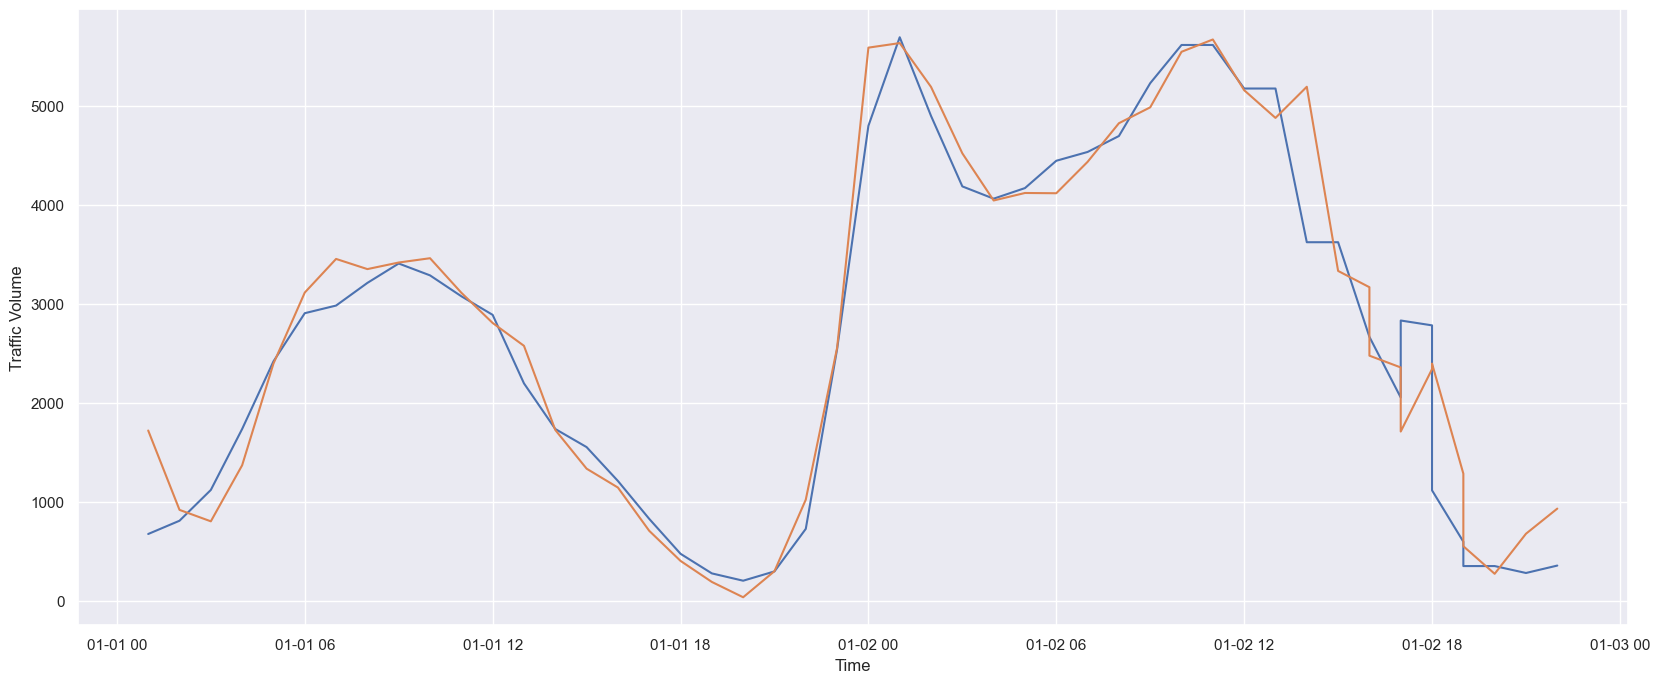

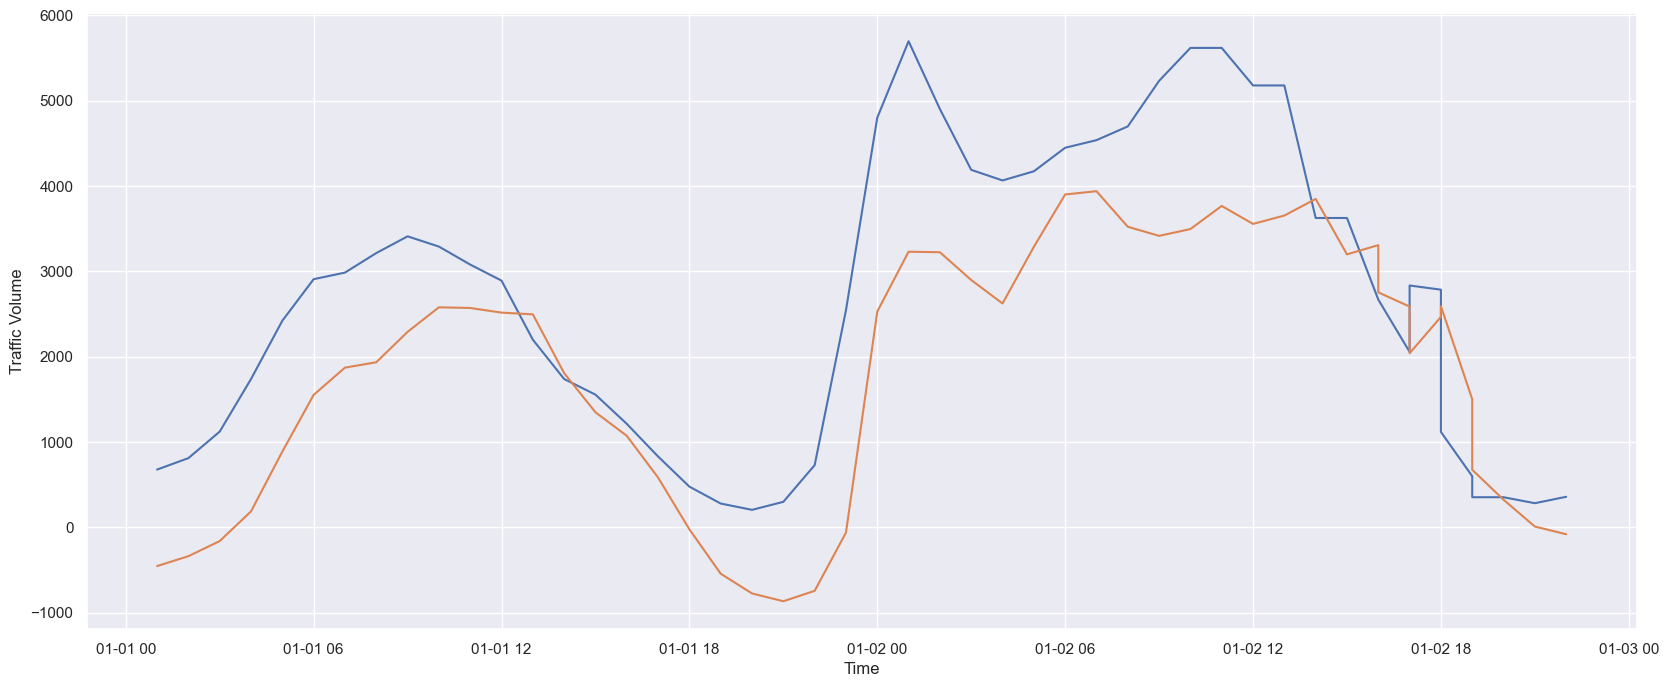

In [50]:
lstm_y_pred = np.array(lstm_Y_pred)
gru_y_pred = np.array(gru_Y_pred)
y_true = np.array(actual_Y_test)

time_test = np.array(test_data['ds'])

plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],lstm_y_pred[:50])
plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],gru_y_pred[:50])

In [51]:
def plot_series_subplot(time, series_true, series_pred, ax,title="",format='-', start=0, end=None):
    xlabels = [str(time[i])[0:13] for i in range(len(time))]
    ax.plot(time[start:end], series_true[start:end],format)
    ax.plot(time[start:end], series_pred[start:end],format)
    ax.set_xlabel('Time')
    ax.set_title(title)
    #ax.set_xticks(time[start:end])
    ax.set_xticklabels(xlabels, rotation=50)
    ax.legend(['Actual','Predicted'], loc='best')
    ax.set_ylabel('Traffic Volume')
    ax.grid(True)

/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotat

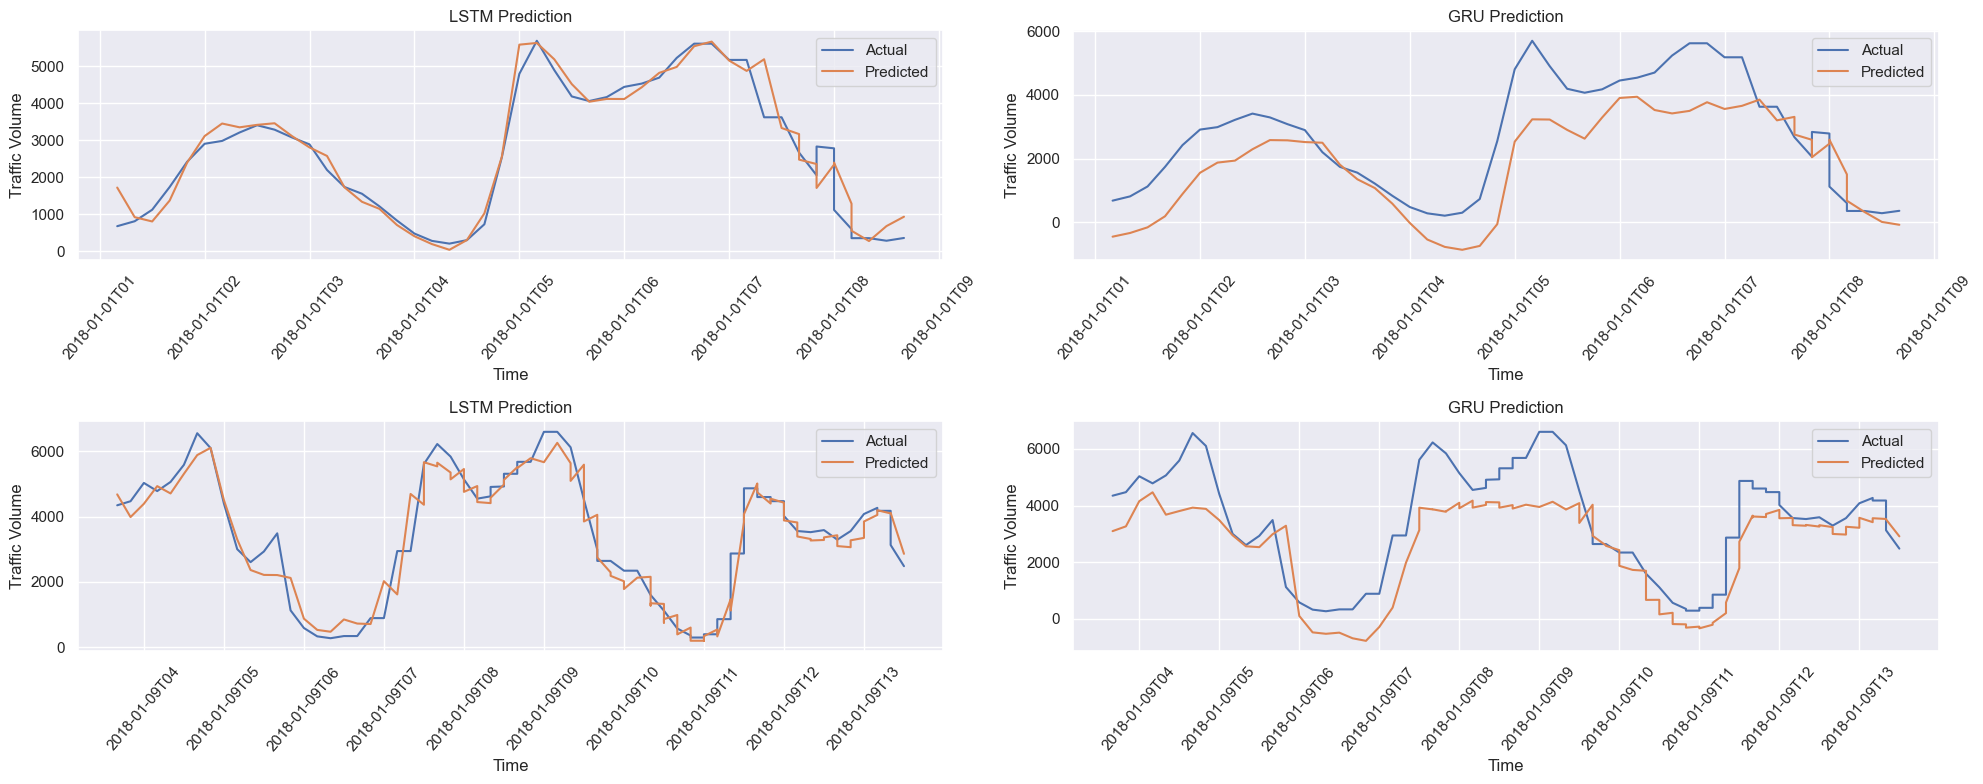

In [52]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[:50], y_true[:50],lstm_y_pred[:50],ax[0][0], "LSTM Prediction")
#plt.figure(figsize=(10,6))
plot_series_subplot(time_test[:50], y_true[:50],gru_y_pred[:50], ax[0][1],"GRU Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],lstm_y_pred[200:300],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],gru_y_pred[200:300], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("/Users/nas/Documents/MRP/dataset/images/prediction_1_"+str(past_observation)+".png", dpi=1200)

/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotat

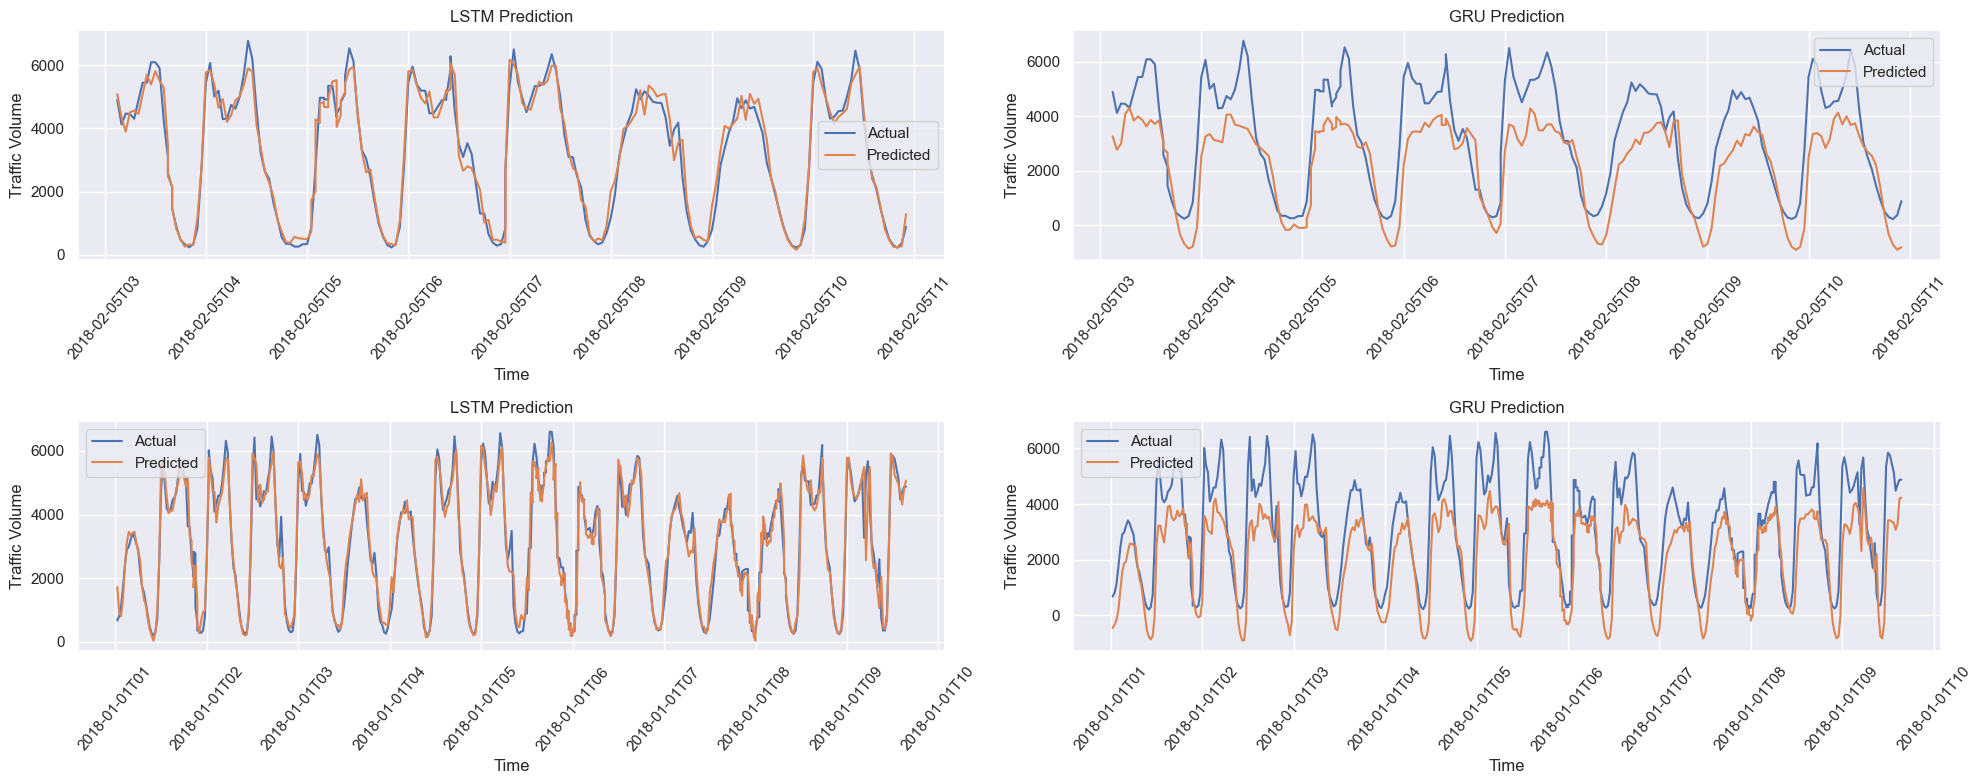

In [53]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],lstm_y_pred[1000:1200],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],gru_y_pred[1000:1200], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[0:500], y_true[0:500],lstm_y_pred[0:500],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[0:500], y_true[0:500],gru_y_pred[0:500], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("/Users/nas/Documents/MRP/dataset/images/prediction_1_"+str(past_observation)+".png", dpi=1200)

/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotat

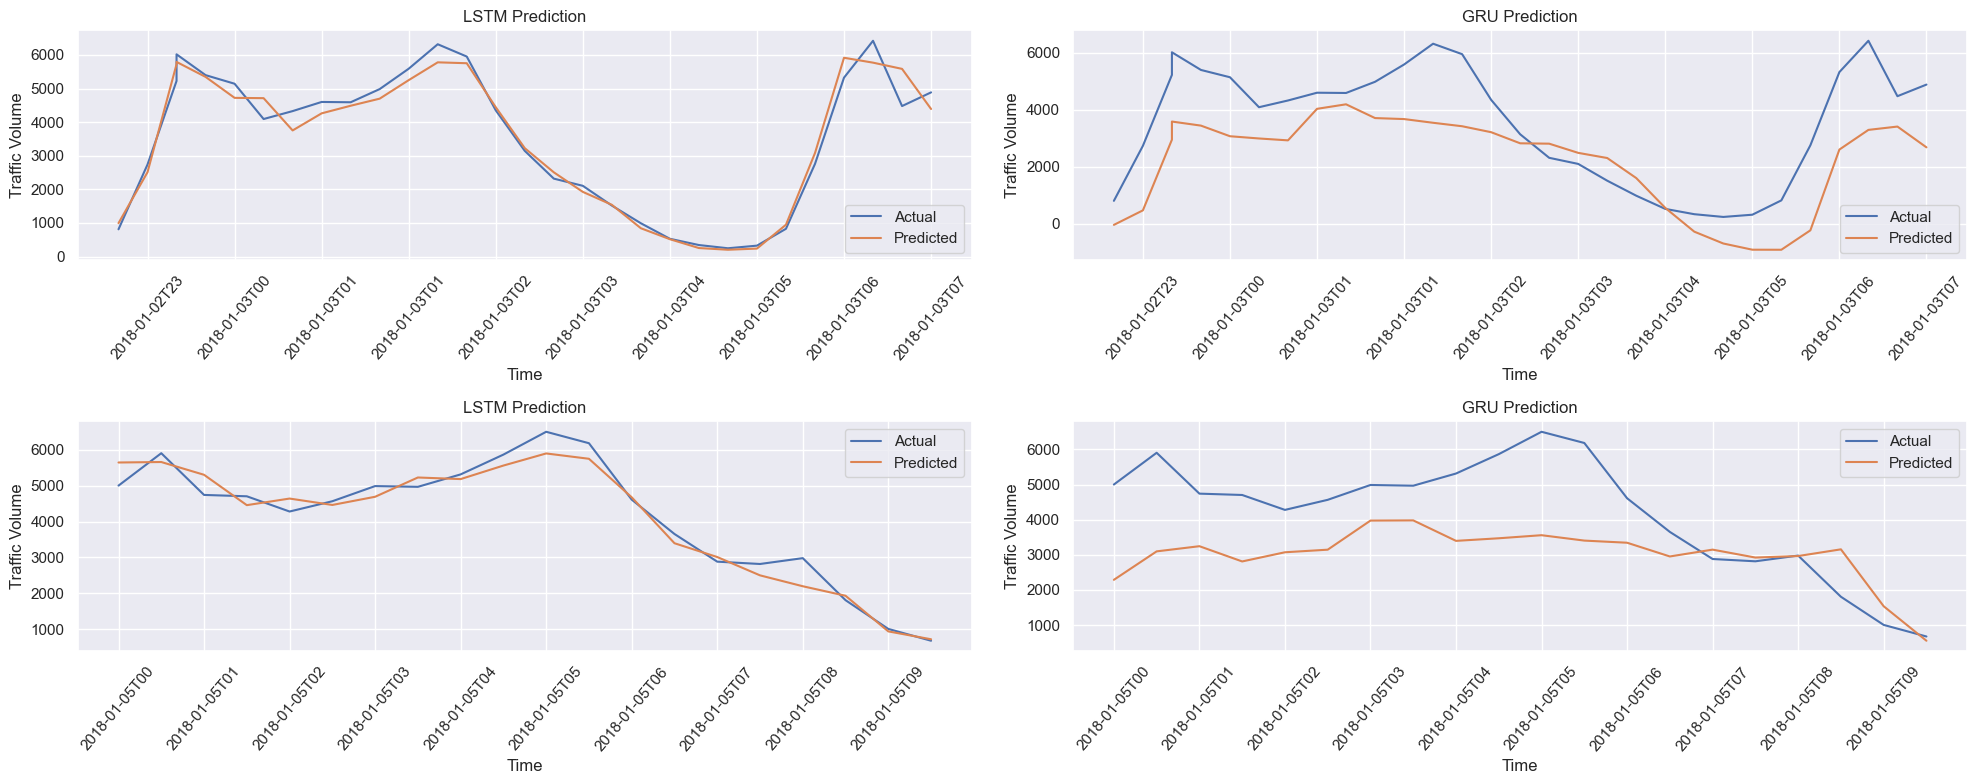

In [54]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[100:120], y_true[100:120],lstm_y_pred[100:120],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[100:120], y_true[100:120],gru_y_pred[100:120], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("/Users/nas/Documents/MRP/dataset/images/prediction_2_"+str(past_observation)+".png", dpi=1200)

/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=50)
/var/folders/_6/_998976521g0_jtnk0hrnh6r0000gn/T/ipykernel_4603/2374997822.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotat

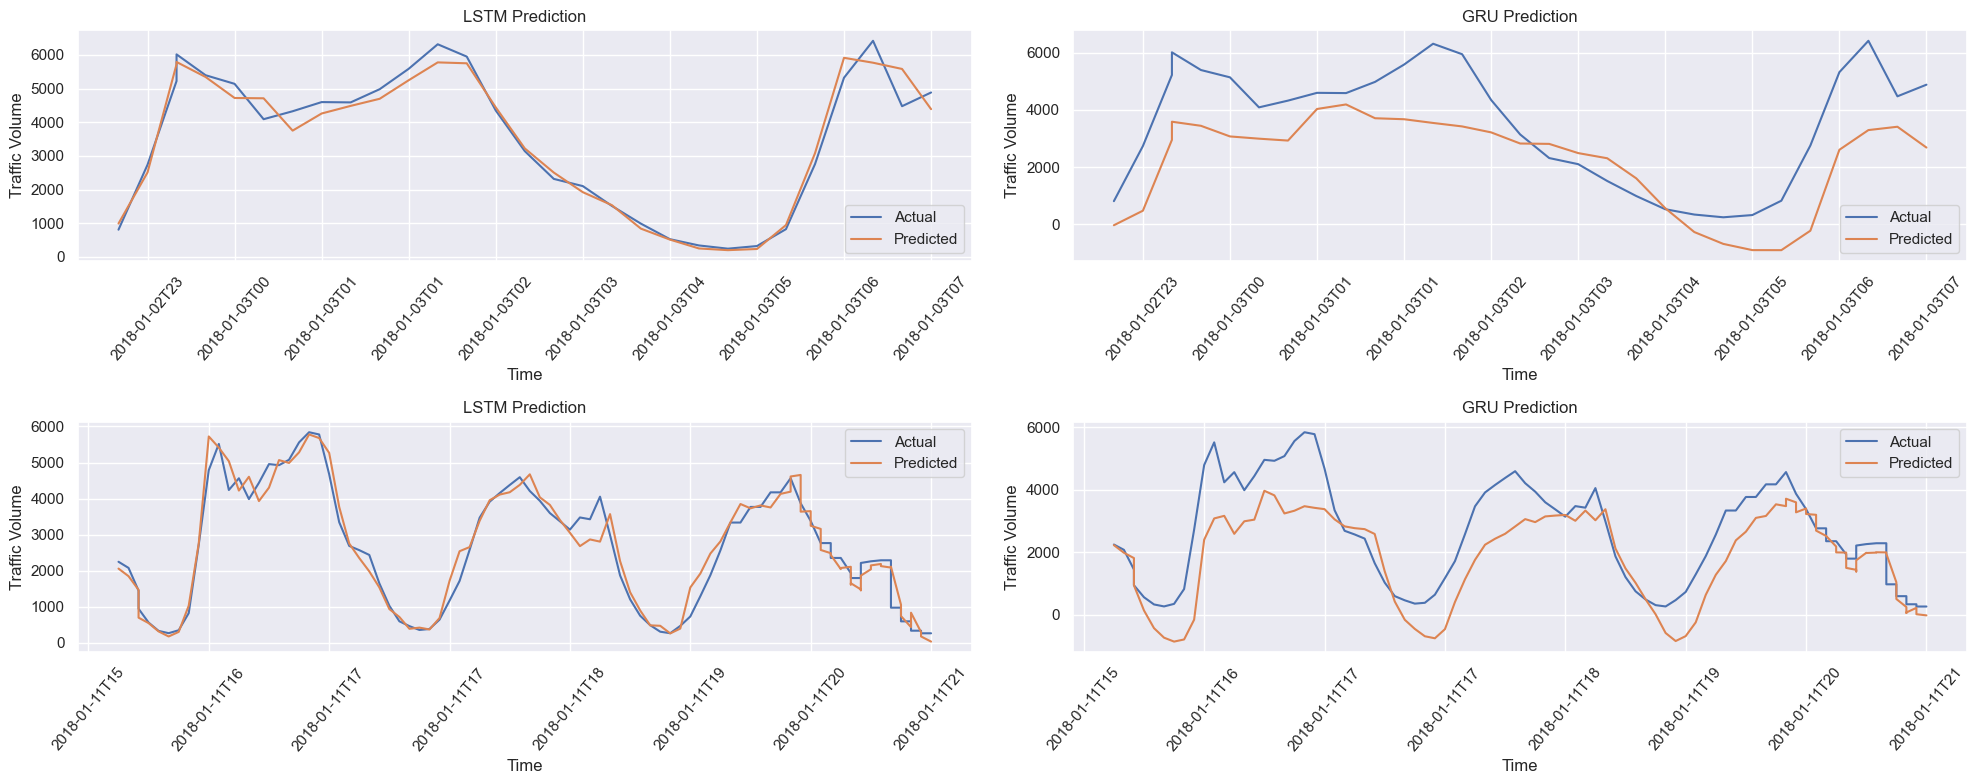

In [55]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[300:400], y_true[300:400],lstm_y_pred[300:400],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[300:400], y_true[300:400],gru_y_pred[300:400], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("/Users/nas/Documents/MRP/dataset/images/prediction_3_"+str(past_observation)+".png", dpi=1200)